# PyTorch Neural Network Classification

### Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
print(circles.head())
circles.label.value_counts()

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


label
1    500
0    500
Name: count, dtype: int64

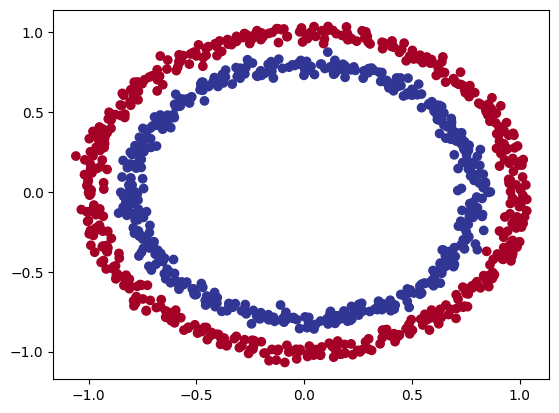

In [2]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [3]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


Split the data into train and test

In [4]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Simple model and training

In [5]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [6]:
from torch import nn

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [7]:
# Training loop

epochs = 100

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model_0(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71462, Accuracy: 49.88% | Test loss: 0.73035, Test acc: 47.00%
Epoch: 10 | Loss: 0.70802, Accuracy: 50.50% | Test loss: 0.72219, Test acc: 46.50%
Epoch: 20 | Loss: 0.70378, Accuracy: 50.38% | Test loss: 0.71646, Test acc: 46.00%
Epoch: 30 | Loss: 0.70090, Accuracy: 50.50% | Test loss: 0.71225, Test acc: 45.50%
Epoch: 40 | Loss: 0.69888, Accuracy: 50.62% | Test loss: 0.70906, Test acc: 46.00%
Epoch: 50 | Loss: 0.69743, Accuracy: 50.50% | Test loss: 0.70657, Test acc: 46.50%
Epoch: 60 | Loss: 0.69636, Accuracy: 50.62% | Test loss: 0.70461, Test acc: 46.50%
Epoch: 70 | Loss: 0.69556, Accuracy: 50.50% | Test loss: 0.70304, Test acc: 46.50%
Epoch: 80 | Loss: 0.69496, Accuracy: 50.62% | Test loss: 0.70176, Test acc: 46.00%
Epoch: 90 | Loss: 0.69451, Accuracy: 50.62% | Test loss: 0.70071, Test acc: 46.00%


It looks like it went through the training and testing steps fine but the results don't seem to have moved too much.

Let's see what the model's predictions look like

In [8]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


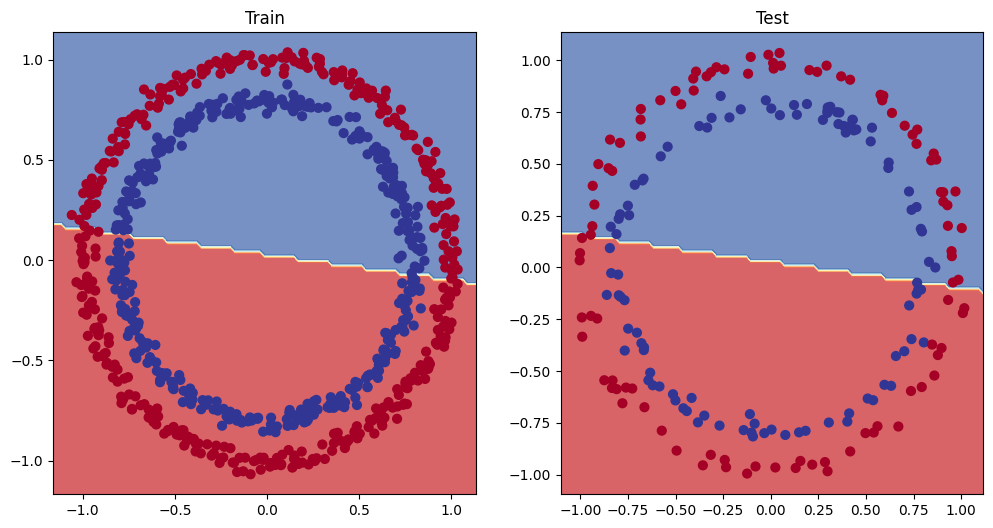

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model 

In [10]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [11]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [12]:
torch.manual_seed(42)
epochs = 1001

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    if epoch % 100 == 0:
        model_3.eval()
        with torch.inference_mode():
            test_logits = model_3(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69487, Accuracy: 50.00% | Test Loss: 0.69413, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69270, Accuracy: 51.25% | Test Loss: 0.69209, Test Accuracy: 57.50%
Epoch: 200 | Loss: 0.69201, Accuracy: 57.38% | Test Loss: 0.69138, Test Accuracy: 58.00%
Epoch: 300 | Loss: 0.69126, Accuracy: 52.38% | Test Loss: 0.69058, Test Accuracy: 52.50%
Epoch: 400 | Loss: 0.69024, Accuracy: 51.88% | Test Loss: 0.68956, Test Accuracy: 51.50%
Epoch: 500 | Loss: 0.68877, Accuracy: 52.50% | Test Loss: 0.68815, Test Accuracy: 49.50%
Epoch: 600 | Loss: 0.68685, Accuracy: 55.88% | Test Loss: 0.68643, Test Accuracy: 52.50%
Epoch: 700 | Loss: 0.68388, Accuracy: 61.00% | Test Loss: 0.68372, Test Accuracy: 59.50%
Epoch: 800 | Loss: 0.67888, Accuracy: 64.25% | Test Loss: 0.67927, Test Accuracy: 64.50%
Epoch: 900 | Loss: 0.67068, Accuracy: 62.88% | Test Loss: 0.67234, Test Accuracy: 64.50%
Epoch: 1000 | Loss: 0.65622, Accuracy: 64.50% | Test Loss: 0.66065, Test Accuracy: 67.00%


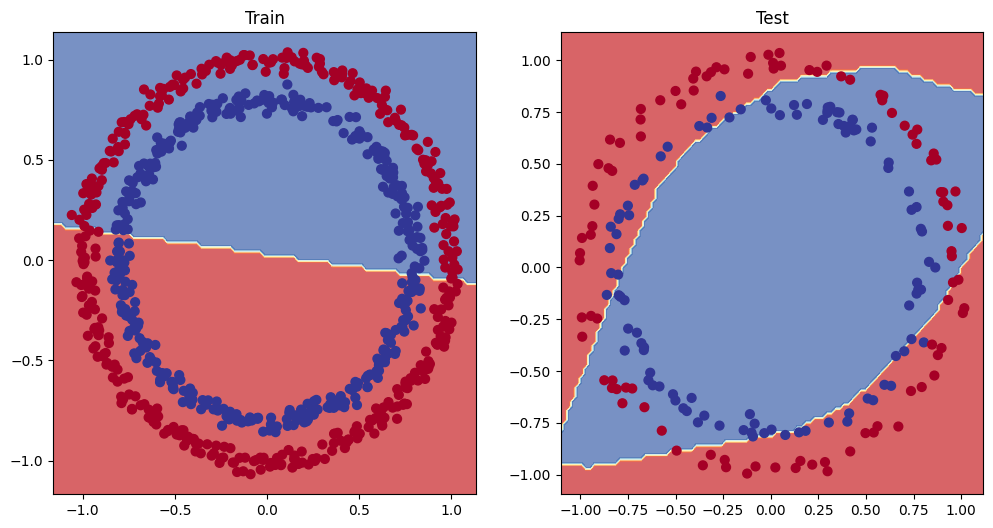

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Exercises

In [14]:
# 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
# For consistency, the dataset should have 1000 samples and a random_state=42.
# Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, random_state=42)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(800, 200)

In [15]:
# 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
# Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_moon = MoonModel()
print(model_moon)

MoonModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
# 3. Setup a binary classification compatible loss function 
# and optimizer to use when training the model.

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_moon.parameters(), lr=0.1)

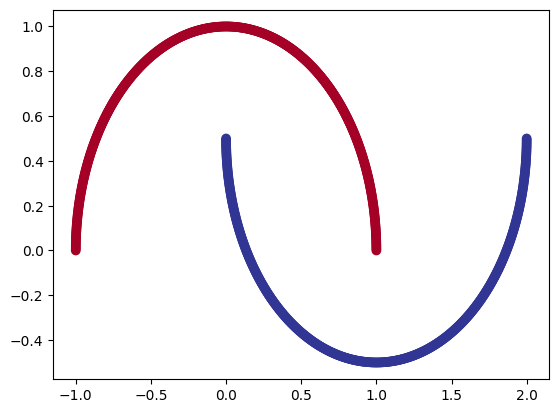

In [17]:
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [18]:
# 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
# To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
# Train the model for long enough for it to reach over 96% accuracy.
# The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.
torch.manual_seed(42)
epochs = 1001
for epoch in range(epochs):
    model_moon.train()
    y_logits = model_moon(X_train).squeeze()
    loss = loss_fn(y_logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model_moon.eval()
        with torch.inference_mode():
            y_pred = torch.round(torch.sigmoid(y_logits))
            acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

            test_logits = model_moon(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69536, Accuracy: 37.25% | Test Loss: 0.69462, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.38584, Accuracy: 81.62% | Test Loss: 0.40274, Test Accuracy: 76.50%
Epoch: 200 | Loss: 0.23521, Accuracy: 88.75% | Test Loss: 0.23915, Test Accuracy: 91.00%
Epoch: 300 | Loss: 0.18844, Accuracy: 91.62% | Test Loss: 0.18707, Test Accuracy: 92.50%
Epoch: 400 | Loss: 0.14797, Accuracy: 93.88% | Test Loss: 0.14573, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.10225, Accuracy: 96.12% | Test Loss: 0.09955, Test Accuracy: 97.50%
Epoch: 600 | Loss: 0.06423, Accuracy: 98.75% | Test Loss: 0.06165, Test Accuracy: 98.50%
Epoch: 700 | Loss: 0.04051, Accuracy: 100.00% | Test Loss: 0.03834, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02720, Accuracy: 100.00% | Test Loss: 0.02539, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01952, Accuracy: 100.00% | Test Loss: 0.01800, Test Accuracy: 100.00%
Epoch: 1000 | Loss: 0.01478, Accuracy: 100.00% | Test Loss: 0.01350, Test Accuracy: 100.00%


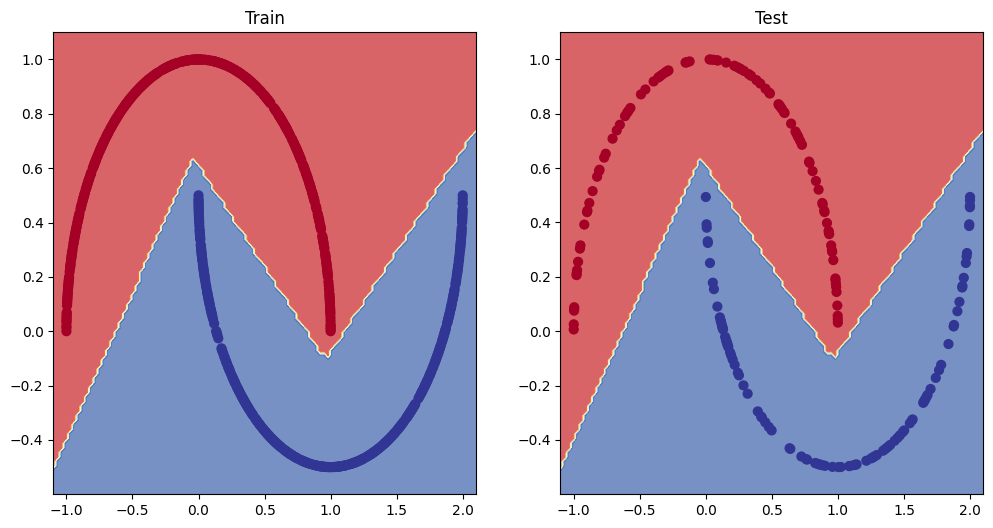

In [19]:
# 5. Make predictions with your trained model and plot them using the
#  plot_decision_boundary() function created in this notebook.

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_moon, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_moon, X_test, y_test)

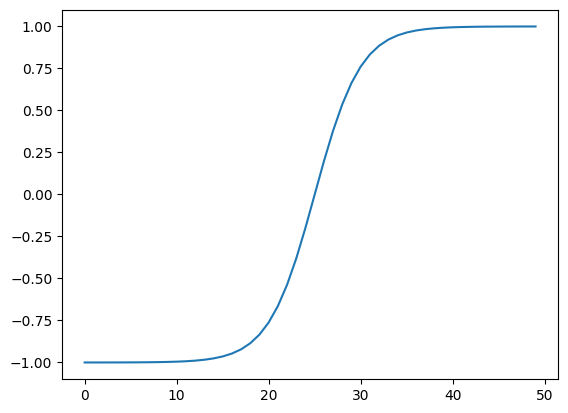

In [20]:
# 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
# Feel free to reference the ML cheatsheet website for the formula.
import numpy as np
data = torch.arange(-5, 5, 0.2)

def tanh(z):
  return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
plt.plot(tanh(data))

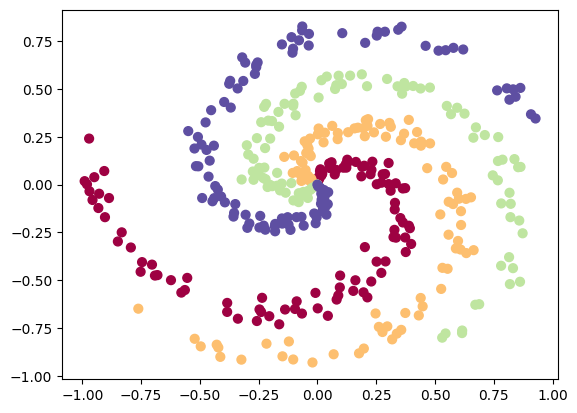

In [47]:
# 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
# Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
# Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
# Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
# Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.
    
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*5,(j+1)*5,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [48]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test)

(320, 80)

In [ ]:
class MultiCLassModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units // 2),
            nn.ReLU(),
            nn.Linear(hidden_units // 2, output_features)
        )

    def forward(self, x):
       return self.linear_layer_stack(x)

model_multiclass = MultiCLassModel(input_features=D, 
                    output_features=K, 
                    hidden_units=8)
print(model_multiclass)

MultiCLassModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_multiclass.parameters(), 
                            lr=0.01)

In [63]:
# Training

torch.manual_seed(42)
epochs = 10001
for epoch in range(epochs):
    model_multiclass.train()

    y_logits = model_multiclass(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_train) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        model_multiclass.eval()
        with torch.inference_mode():
            acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
            
            test_logits = model_multiclass(X_test)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                    y_pred=test_pred)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 1.40975, Accuracy: 23.12% | Test Loss: 1.38369, Test Accuracy: 32.50%
Epoch: 1000 | Loss: 1.35030, Accuracy: 33.75% | Test Loss: 1.36665, Test Accuracy: 28.75%
Epoch: 2000 | Loss: 1.28343, Accuracy: 32.81% | Test Loss: 1.30044, Test Accuracy: 37.50%
Epoch: 3000 | Loss: 1.22506, Accuracy: 31.56% | Test Loss: 1.22803, Test Accuracy: 36.25%
Epoch: 4000 | Loss: 1.19832, Accuracy: 32.19% | Test Loss: 1.19731, Test Accuracy: 37.50%
Epoch: 5000 | Loss: 1.17671, Accuracy: 33.44% | Test Loss: 1.17832, Test Accuracy: 38.75%
Epoch: 6000 | Loss: 1.15649, Accuracy: 36.88% | Test Loss: 1.16056, Test Accuracy: 37.50%
Epoch: 7000 | Loss: 1.13504, Accuracy: 38.75% | Test Loss: 1.14375, Test Accuracy: 40.00%
Epoch: 8000 | Loss: 1.11271, Accuracy: 40.00% | Test Loss: 1.12879, Test Accuracy: 43.75%
Epoch: 9000 | Loss: 1.08941, Accuracy: 40.94% | Test Loss: 1.11424, Test Accuracy: 43.75%
Epoch: 10000 | Loss: 1.06144, Accuracy: 43.75% | Test Loss: 1.09154, Test Accuracy: 43.75%


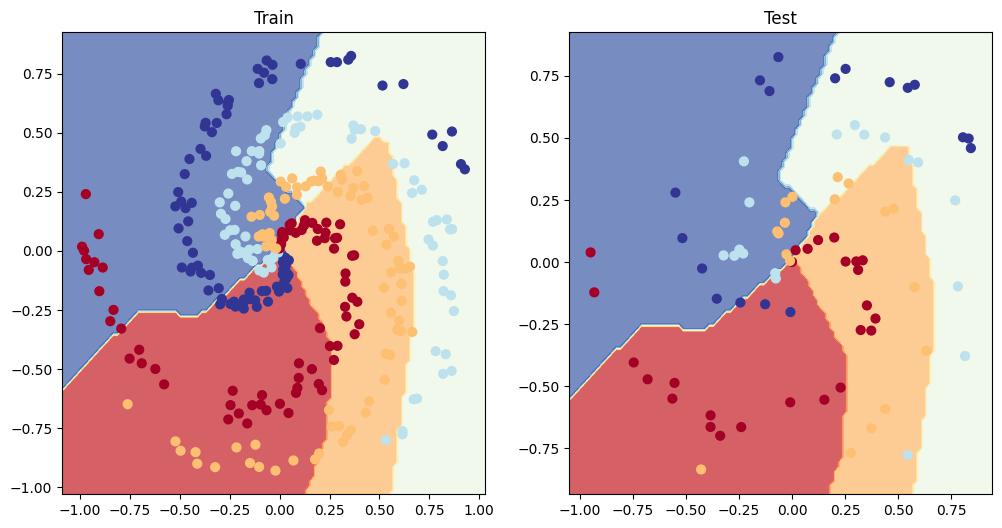

In [64]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_multiclass, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_multiclass, X_test, y_test)